## University of Wisconsin at Madison Examination of Grade Distributions 

The University of Wisconsin at Madison (UW-M) administration is concerned about enrollment, retention and graduation rates. As part of addressing this concern, was an examination of grades across all subjects over the 2006 - 2017. The goal was to understand four issues: 1. if STEM fields had different grade distributions than traditional liberal arts subjects, 2. Did large classes (more than 32 students, which is the 75th percentile of enrollment) had different grade distribution than smaller classes, 3. Does the time of day (before or after lunch) make a difference in grades, 4. Has there been a change in grade distributions over the 10 years of the dataset. The assumption is that grades are a proxy for student success and knowledge gained. UW-M publishes reports for all courses (and sections of these courses), instructors, subjects, and grade reports for each section for every Fall and Spring semester since 2006.

There are more than 9,000 courses in this dataset. There are nearly 200,000 course sections with grades, with 3 million grades reported in total. 18,000 instructors are included in the dataset, all of whom are associated with various sections that may or may not have grades reported for them.

The data was retrieved from the UW Madison registrar office, and extracted from PDF files using the open source tool, madgrades-extractor. This information was publicaly available on kaggle.

### Load the data and needed libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlite3
from scipy.stats import ttest_ind
import scipy.stats as stats

In [3]:
conn = sqlite3.connect('uw-madison-courses/database.sqlite3')

In [4]:
c = conn.cursor()
c.execute("""SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE "sqlite%";""").fetchall()


[('sections',),
 ('instructors',),
 ('course_offerings',),
 ('subject_memberships',),
 ('courses',),
 ('rooms',),
 ('teachings',),
 ('subjects',),
 ('schedules',),
 ('grade_distributions',),
 ('terms',)]

In [5]:
c.execute('PRAGMA table_info(course_offerings)').fetchall()

[(0, 'uuid', 'TEXT', 0, None, 0),
 (1, 'course_uuid', 'TEXT', 0, None, 0),
 (2, 'term_code', 'TEXT', 0, None, 0),
 (3, 'name', 'TEXT', 0, None, 0)]

In [6]:
c.execute('PRAGMA table_info(sections)').fetchall()

[(0, 'uuid', 'TEXT', 0, None, 0),
 (1, 'course_offering_uuid', 'TEXT', 0, None, 0),
 (2, 'section_type', 'TEXT', 0, None, 0),
 (3, 'number', 'TEXT', 0, None, 0),
 (4, 'room_uuid', 'TEXT', 0, None, 0),
 (5, 'schedule_uuid', 'TEXT', 0, None, 0)]

In [7]:
#df_terms = pd.read_csv("term_code.csv")

In [8]:
#df_terms.to_sql("terms", conn)

In [9]:
df = pd.DataFrame(c.execute("""
SELECT * FROM grade_distributions AS gd, course_offerings AS co, terms

WHERE co.uuid = gd.course_offering_uuid
AND terms.`Term Number` = co.term_code

""").fetchall())
df.columns = [i[0] for i in c.description]
df.head()

#

,course_offering_uuid,section_number,n_count,c_count,f_count,cr_count,p_count,nw_count,other_count,bc_count,...,i_count,b_count,nr_count,uuid,course_uuid,term_code,name,index,Calendar Year,Term Number
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,0,0,0,0,0,0,0,0,...,0,0,0,344b3ebe-da7e-314c-83ed-9425269695fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1092,Cooperative Education Prog,106,2008,1092
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,0,0,0,0,0,0,0,0,...,1,0,0,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1082,Cooperative Education Prog,105,2007,1082
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,0,3,0,0,0,0,0,0,...,0,2,0,ea3b717c-d66b-30dc-8b37-964d9688295f,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1172,Cooperative Education Prog,114,2016,1172
3,075da420-5f49-3dd0-93df-13e3c152e1b1,1,0,0,0,0,0,0,0,0,...,1,0,0,075da420-5f49-3dd0-93df-13e3c152e1b1,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1114,Cooperative Education Prog,10,2011,1114
4,2b4e216d-a728-3713-8c7c-19afffc6b2fd,1,0,0,0,0,0,0,0,0,...,1,0,0,2b4e216d-a728-3713-8c7c-19afffc6b2fd,a3e3e1c3-543d-3bb5-ae65-5f2aec4ad1de,1104,Cooperative Education Prog,9,2010,1104


In [10]:
df["year"] = df["Calendar Year"]


In [11]:
df.columns

Index(['course_offering_uuid', 'section_number', 'n_count', 'c_count',
       'f_count', 'cr_count', 'p_count', 'nw_count', 'other_count', 'bc_count',
       'u_count', 'd_count', 'ab_count', 'a_count', 's_count', 'i_count',
       'b_count', 'nr_count', 'uuid', 'course_uuid', 'term_code', 'name',
       'index', 'Calendar Year', 'Term Number', 'year'],
      dtype='object')

### Exploratory Data Analysis of Question 2 - Do large classes have different grade distributions

In [12]:
#Class grade counts were saved as text, converted to numbers
df[['n_count', 'c_count', 'f_count', 'cr_count', 'p_count', 'nw_count', 'other_count', 'bc_count', 'u_count', 'd_count', 'ab_count', 'a_count', 's_count', 'i_count', 'b_count', 'nr_count']] = df[['n_count', 'c_count', 'f_count', 'cr_count', 'p_count', 'nw_count', 'other_count', 'bc_count','u_count', 'd_count', 'ab_count', 'a_count', 's_count', 'i_count',
       'b_count', 'nr_count']].astype(int)
    

In [13]:
#Create class enrollment feature, sum of all grade counts. Excluded all non-grade counts,
#(satisfactory, unsatisfactory, credit, no credit, progress, incomplete, and no report)
df['enrollment'] = df[['c_count', 'nw_count', 'f_count', 'bc_count', 'd_count', 'ab_count', 
                       'a_count', 'b_count']].sum(axis = 1)
df['enrollment'].head()

0    105
1    158
2    156
3     87
4     70
Name: enrollment, dtype: int64

In [14]:
#More than 100,000 or 52% classes have zero grades, which is the proxy for class enrollment. 
#The class with the most zero-grades is Research (13,074), and other research/thesis classes 
#are at the top. The bottom lists more unique classes like Thai Poetry that only have one or two empty classes.

df['enrollment'].value_counts().head()

0     106016
6       3653
8       3486
13      3408
7       3400
Name: enrollment, dtype: int64

In [15]:
# Get rid of the empty classes without grades. Unrelated to our research
df = df[df["enrollment"] != 0]
df['enrollment'].value_counts().head()

6     3653
8     3486
13    3408
7     3400
12    3394
Name: enrollment, dtype: int64

In [16]:
# Calculate a total grade point for each class based on 
# registrar listing: https://registrar.wisc.edu/grades-and-gpa/
df['cum_grade'] = df['a_count'] * 4 + df['ab_count'] * 3.5 + df['b_count'] * 3.0 + df['bc_count'] * 2.5 \
+ df['c_count'] * 2.0 + df['d_count']


In [17]:
# create a GPA value for the class
df['class_gpa'] = df['cum_grade'] / df['enrollment']

In [18]:
# Calculate percentages for each grade

df["a_count_pct"] = df["a_count"]/df["enrollment"]
df["ab_count_pct"] = df["ab_count"]/df["enrollment"]
df["b_count_pct"] = df["b_count"]/df["enrollment"]
df["bc_count_pct"] = df["bc_count"]/df["enrollment"]
df["c_count_pct"] = df["c_count"]/df["enrollment"]
df["d_count_pct"] = df["d_count"]/df["enrollment"]
df["f_count_pct"] = df["f_count"]/df["enrollment"]
df["nw_count_pct"] = df["nw_count"]/df["enrollment"]

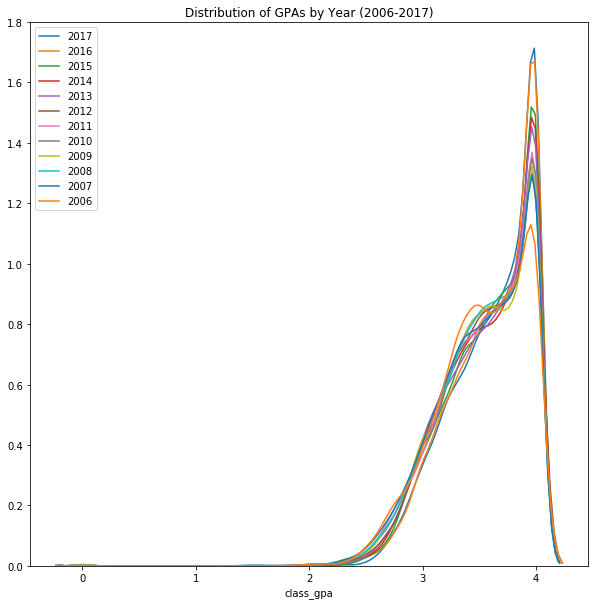

In [19]:
#Plot distribution of GPAs

fig = plt.figure(figsize=(10,10))
plt.title("Distribution of GPAs by Year (2006-2017)")
year_means = []

for y in sorted(df["year"].unique(), reverse=True):
    temp = df[df["year"] == y]
    sns.distplot(temp['class_gpa'], label=y, kde=True, hist=False)
    year_gpa = sum(temp["cum_grade"])/sum(temp["enrollment"])
    year_means.append([y, temp['class_gpa'].mean(), year_gpa])
plt.legend()

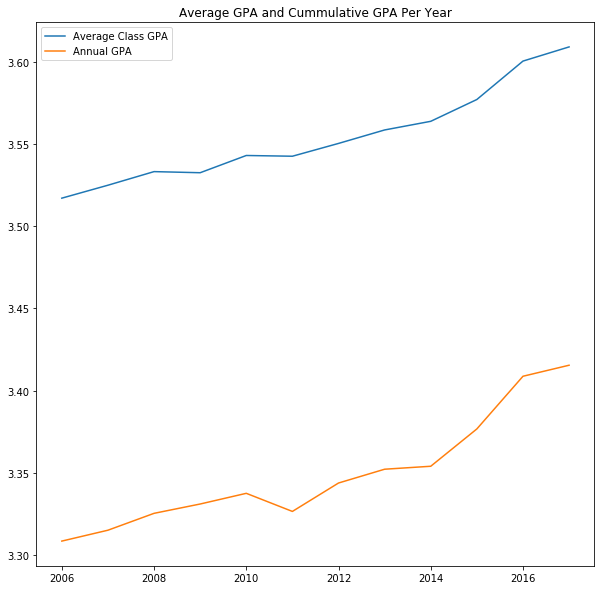

In [20]:
fig = plt.figure(figsize=(10,10))
plt.title("Average GPA and Cummulative GPA Per Year")
plt.plot([i[0] for i in year_means], [i[1] for i in year_means], label="Average Class GPA")
plt.plot([i[0] for i in year_means], [i[2] for i in year_means], label="Annual GPA")

plt.legend()

In [27]:
[(i[0], i[2]) for i in year_means]

[(2017, 3.4154966102322826),
 (2016, 3.4087886544353974),
 (2015, 3.376758086591937),
 (2014, 3.354065488101225),
 (2013, 3.352267790115455),
 (2012, 3.343876047295194),
 (2011, 3.3266034239067728),
 (2010, 3.337610452246837),
 (2009, 3.3311118785772615),
 (2008, 3.325442444136208),
 (2007, 3.315182213440171),
 (2006, 3.30856645236201)]

There are more small classes with very high GPAs (4.0s) but does that mean that smaller classes get higher GPAs on average? The mean GPA is certainly higher for smaller classes.

In [73]:
from statsmodels.formula.api import ols

In [30]:
df2 = df

In [33]:
df2 = pd.get_dummies(df2,columns=["year"])

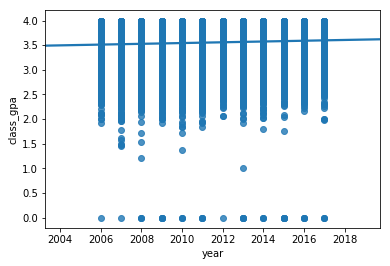

In [29]:
sns.regplot("year", "class_gpa", data=df2)

In [81]:
model = ols(formula="class_gpa~C(year)", data=df).fit()
print(model.summary())
print(model.pvalues)
print(model.rsquared)
print(model.params) #arrays (Intercept, slope)


                            OLS Regression Results                            
Dep. Variable:              class_gpa   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     41.29
Date:                Thu, 06 Jun 2019   Prob (F-statistic):           3.17e-90
Time:                        17:15:37   Log-Likelihood:                -40119.
No. Observations:               87246   AIC:                         8.026e+04
Df Residuals:                   87234   BIC:                         8.037e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.5171      0.006    5

In [79]:
import statsmodels.api as sm
table = sm.stats.anova_lm(model, typ=2)

In [83]:
print(table)

                sum_sq       df           F        PR(>F)
year         61.800276      1.0  420.612094  2.983473e-93
Residual  12818.707139  87244.0         NaN           NaN


In [ ]:
stats.f.ppf()

In [34]:
df_2006 = df[df["year"] == 2006]
df_2017 = df[df["year"] == 2017]

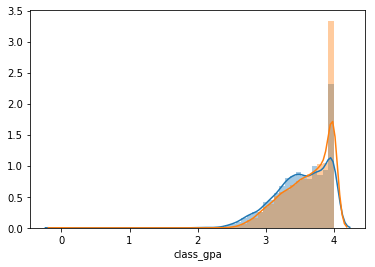

In [35]:
sns.distplot(df_2006["class_gpa"])
sns.distplot(df_2017["class_gpa"])

In [36]:
def t_calc(x, y):
    return (x.mean() - y.mean()) \
/  (len(x) *  np.std(x) + len(y) * np.std(y) \
/  (len(x)  +  len(y)  - 2))

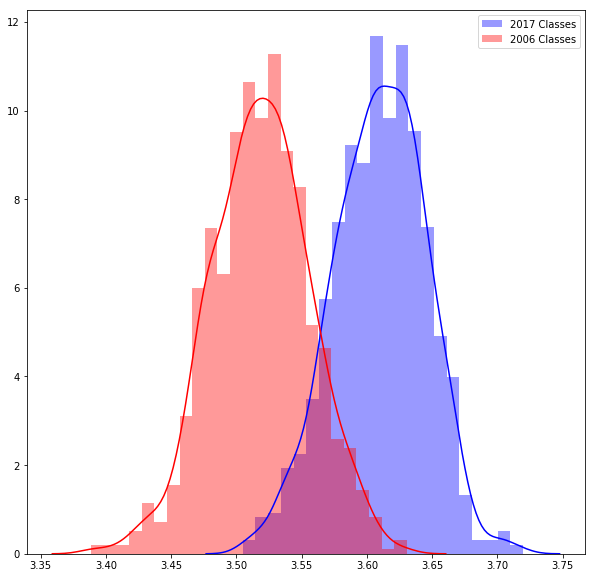

In [38]:
fig = plt.figure(figsize=(10,10))

large_samples = []
small_samples = []
for i in range(1000):
    sample1 = df_2006.sample(100)['class_gpa']
    small_samples.append(sample1.mean())
    
    sample2 = df_2017.sample(100)['class_gpa']
    large_samples.append(sample2.mean())

sns.distplot(large_samples, color="blue", label="2017 Classes")
sns.distplot(small_samples, color="red", label="2006 Classes")
plt.legend()


In [46]:
t_val = t_calc(np.array(large_samples), np.array(small_samples))
t_val

0.0026018477534794

In [50]:
from scipy import stats
d_of_f = 100 - 1

t_critical = stats.t.ppf(.05, df=d_of_f, loc=np.mean(large_samples), scale=np.std(large_samples))

t_val_per = stats.t.ppf(t_val, df=d_of_f, loc=np.mean(large_samples), scale=np.std(large_samples))
print(t_critical, t_val_per)
print("Is t < t_critical: %s" % (t_val_per < t_critical))

3.5514664518233086 3.509435409002865
Is t < t_critical: True


Text(3.4214664518233087, 10, 'α=.05')

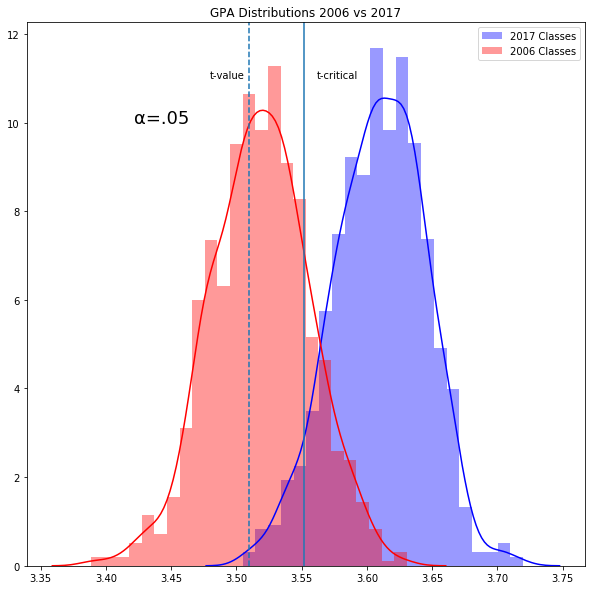

In [67]:
fig = plt.figure(figsize=(10,10))
plt.title("GPA Distributions 2006 vs 2017")

sns.distplot(large_samples, color="blue", label="2017 Classes")
sns.distplot(small_samples, color="red", label="2006 Classes")
plt.axvline(x=t_critical)
plt.text(t_critical + .01, 11,'t-critical')
plt.axvline(x=t_val_per, linestyle="--")
plt.text(t_val_per - .03, 11,'t-value')
plt.legend()

plt.text(t_critical - .13, 10,'α=.05', fontsize=18)

In [54]:
p_val = stats.norm.ppf(t_val, d_of_f)
print(100 - p_val)

3.794146149883204


In [71]:
from scipy import stats
d_of_f = 100 - 1

t_critical = stats.norm.ppf(.05)

t_val_per = stats.norm.ppf(t_val)
print(t_critical, t_val_per)
print("Is t < t_critical: %s" % (t_val_per < t_critical))

-1.6448536269514729 -2.794146149883211
Is t < t_critical: True


In [75]:
import math
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / math.sqrt(((nx-1)*np.std(x, ddof=(nx-1)) ** 2 + (ny-1)*np.std(y, ddof=(ny-1)) ** 2) / dof)
print(cohen_d(large_samples, small_samples))

0.07942059155653867
